# PREPROCESSING

## GET DATA

In [1]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import LancasterStemmer
import seaborn as sns
import nltk
import string
import re
from sklearn.utils import resample
from nltk.corpus import stopwords

In [16]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nlp = spacy.load('en_core_web_lg')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [33]:
df = pd.read_csv('Data/tripadvisor_hotel_reviews.csv')

In [4]:
df.columns = ['Review', 'Rating']
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
def encode_rating(rating):
    if rating > 3:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

In [6]:
df['setiment'] = df['Rating'].apply(encode_rating)

## DOWNSAMPLE

<Axes: xlabel='setiment'>

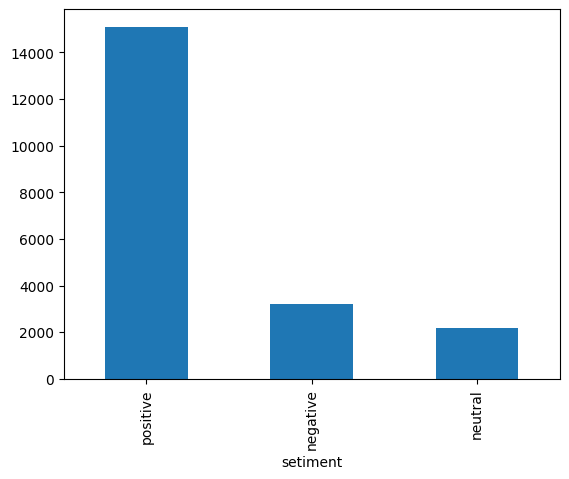

In [7]:
df['setiment'].value_counts().plot(kind='bar')

In [8]:
df['setiment'].value_counts()

setiment
positive    15093
negative     3214
neutral      2184
Name: count, dtype: int64

In [46]:
# df_new = pd.DataFrame()
# target_count = 1421

# for rating, group in df.groupby('Rating'):
#     if len(group) > target_count:
#         ratings_new = resample(group, replace=False, n_samples=target_count, random_state=42)
#     else:
#         ratings_new = group
#     df_new = pd.concat([df_new, ratings_new])

# df = df_new.reset_index(drop=True)
# df['Rating'].value_counts()

## CLEANING

In [47]:
def create_label(rating):
    if rating > 3:
        return 'positive'
    elif rating < 3:
        return 'negative'
    else:
        return 'neutral'

In [48]:
def remove_punctuation(text):
    text = ''.join([char if char not in string.punctuation else ' ' for char in text]).lower()
    return text

In [49]:
def additional_cleaning(text):
    text = re.sub(r'\bn t\b', 'not', text)
    text = re.sub(r'\bnt\b', 'not', text)
    text = re.sub(r'\bdidn t\b', 'did not', text)
    text = re.sub(r'\bdidn\b', 'did not', text)
    text = re.sub(r'\bdon t\b', 'do not', text)
    text = re.sub(r'\bdon\b', 'do not', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text


In [50]:
df['label'] = df['Rating'].apply(lambda x: create_label(x))
df['clean_punc'] = df['Review'].apply(lambda x: remove_punctuation(x)).apply(lambda x: additional_cleaning(x))

In [51]:
df.head()

,Review,Rating,label,clean_punc
0,nice hotel expensive parking got good deal sta...,4,positive,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,negative,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,neutral,nice rooms not 4 experience hotel monaco seat...
3,"unique, great stay, wonderful time hotel monac...",5,positive,unique great stay wonderful time hotel monac...
4,"great stay great stay, went seahawk game aweso...",5,positive,great stay great stay went seahawk game aweso...


## STOPWORD & LEMMATIZATION

In [52]:
stopwords_list = stopwords.words('english')
def remove_stopwords(text):
    token_words = text.split()
    filtered_words = []
    for word in token_words:
        if word not in stopwords_list:
            filtered_words.append(word)
    return ' '.join(filtered_words)

In [53]:
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

In [54]:
def remove_token_with_word_and_number(text):
    words = text.split()
    filtered_words = []
    for word in words:
        if not any(char.isdigit() for char in word):
            filtered_words.append(word)
    return ' '.join(filtered_words)


In [55]:
def perform_ner(text):
    doc = nlp(text)
    replaced_text = []
    for token in doc:
        if token.ent_type_:
            replaced_text.append(token.ent_type_)
        else:
            replaced_text.append(token.text)
    
    return ' '.join(replaced_text)


In [56]:
df['lemmatized_review'] = df['clean_punc'].apply(lambda x: lemmatize_text(x))
df['number_review'] = df['lemmatized_review'].apply(lambda x: remove_token_with_word_and_number(x))

In [57]:
df['ner_review'] = df['number_review'].apply(lambda x: perform_ner(x))

In [61]:
print('Original Review:\t', df['Review'][4])
print('Lemmatized Review:\t', df['lemmatized_review'][4])
print('Token Number Review:\t', df['number_review'][4])
print('Name Entity R Review:\t', df['ner_review'][4])

Original Review:	 great stay great stay, went seahawk game awesome, downfall view building did n't complain, room huge staff helpful, booked hotels website seahawk package, no charge parking got voucher taxi, problem taxi driver did n't want accept voucher barely spoke english, funny thing speak arabic called started making comments girlfriend cell phone buddy, took second realize just said fact speak language face priceless, ass told, said large city, told head doorman issue called cab company promply answer did n't, apologized offered pay taxi, bucks 2 miles stadium, game plan taxi return going humpin, great walk did n't mind, right christmas wonderful lights, homeless stowed away building entrances leave, police presence not greatest area stadium, activities 7 blocks pike street waterfront great coffee shops way, hotel mantained foyer awesome, wine tasting available evening, best dog, taking st. bernard time family, safes hotel located service desk room, bathroom huge jetted tub hug

In [59]:
df.head()

,Review,Rating,label,clean_punc,lemmatized_review,number_review,ner_review
0,nice hotel expensive parking got good deal sta...,4,positive,nice hotel expensive parking got good deal sta...,nice hotel expensive parking get good deal sta...,nice hotel expensive parking get good deal sta...,nice hotel expensive parking get good deal sta...
1,ok nothing special charge diamond member hilto...,2,negative,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member PERSO...
2,nice rooms not 4* experience hotel monaco seat...,3,neutral,nice rooms not 4 experience hotel monaco seat...,nice room not 4 experience hotel monaco seat...,nice room not experience hotel monaco seattle ...,nice room not experience hotel monaco seattle ...
3,"unique, great stay, wonderful time hotel monac...",5,positive,unique great stay wonderful time hotel monac...,unique great stay wonderful time hotel mon...,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time ORG ORG locat...
4,"great stay great stay, went seahawk game aweso...",5,positive,great stay great stay went seahawk game aweso...,great stay great stay go seahawk game awesom...,great stay great stay go seahawk game awesome ...,great stay great stay go ORG game awesome down...


In [60]:
df.to_csv('Data/cleaned_hotel_reviews.csv', index=False)